In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import frame_whitening as fw
import frame_whitening.data as fwd
import frame_whitening.simulation_new as fws

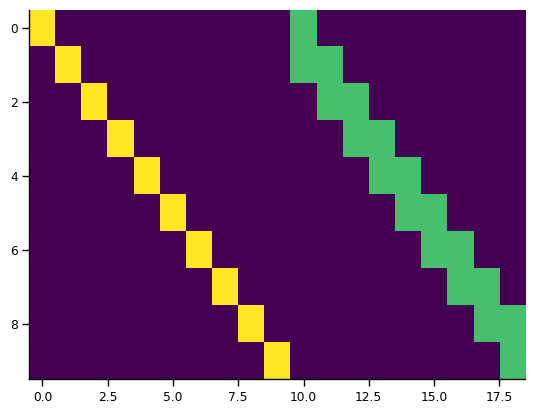

In [53]:
N = 10
neighborhood_size = 2
W = fw.get_conv_frame(N, 1, neighborhood_size, 1)
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(W, aspect="auto")
    sns.despine()

In [54]:
seed = 42069
rng = np.random.default_rng(seed)

A = rng.standard_normal((N, N))
Cxx = A @ A.T 
Cxx0 = Cxx + + 1e-4 * np.eye(N)

Lxx = np.linalg.cholesky(Cxx0)

# simulate data
batch_size = -1
n_batch = 2048
step_skip = 1
g_last, g_all, errors, variances = fws.simulate(
                                        cholesky_list=[Lxx], 
                                        W=W, 
                                        batch_size=-1, 
                                        n_batch=n_batch, 
                                        lr_g=3E-2,
                                        g0=None, 
                                        online=False, 
                                        clamp=False,
                                        alpha=1.,
                                        save_every=step_skip,
                                    )

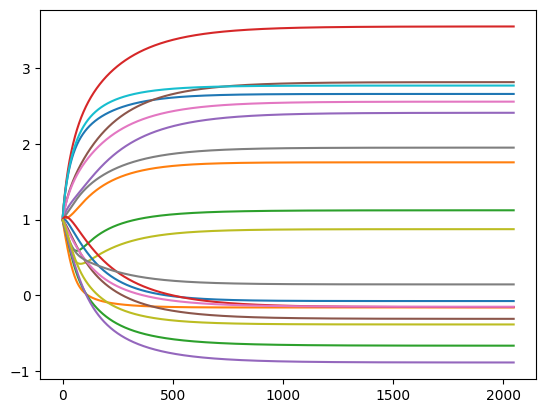

In [55]:
M = np.linalg.inv(np.eye(N) + W @ (g_last[0][:, None] * W.T))
plt.plot(g_all);

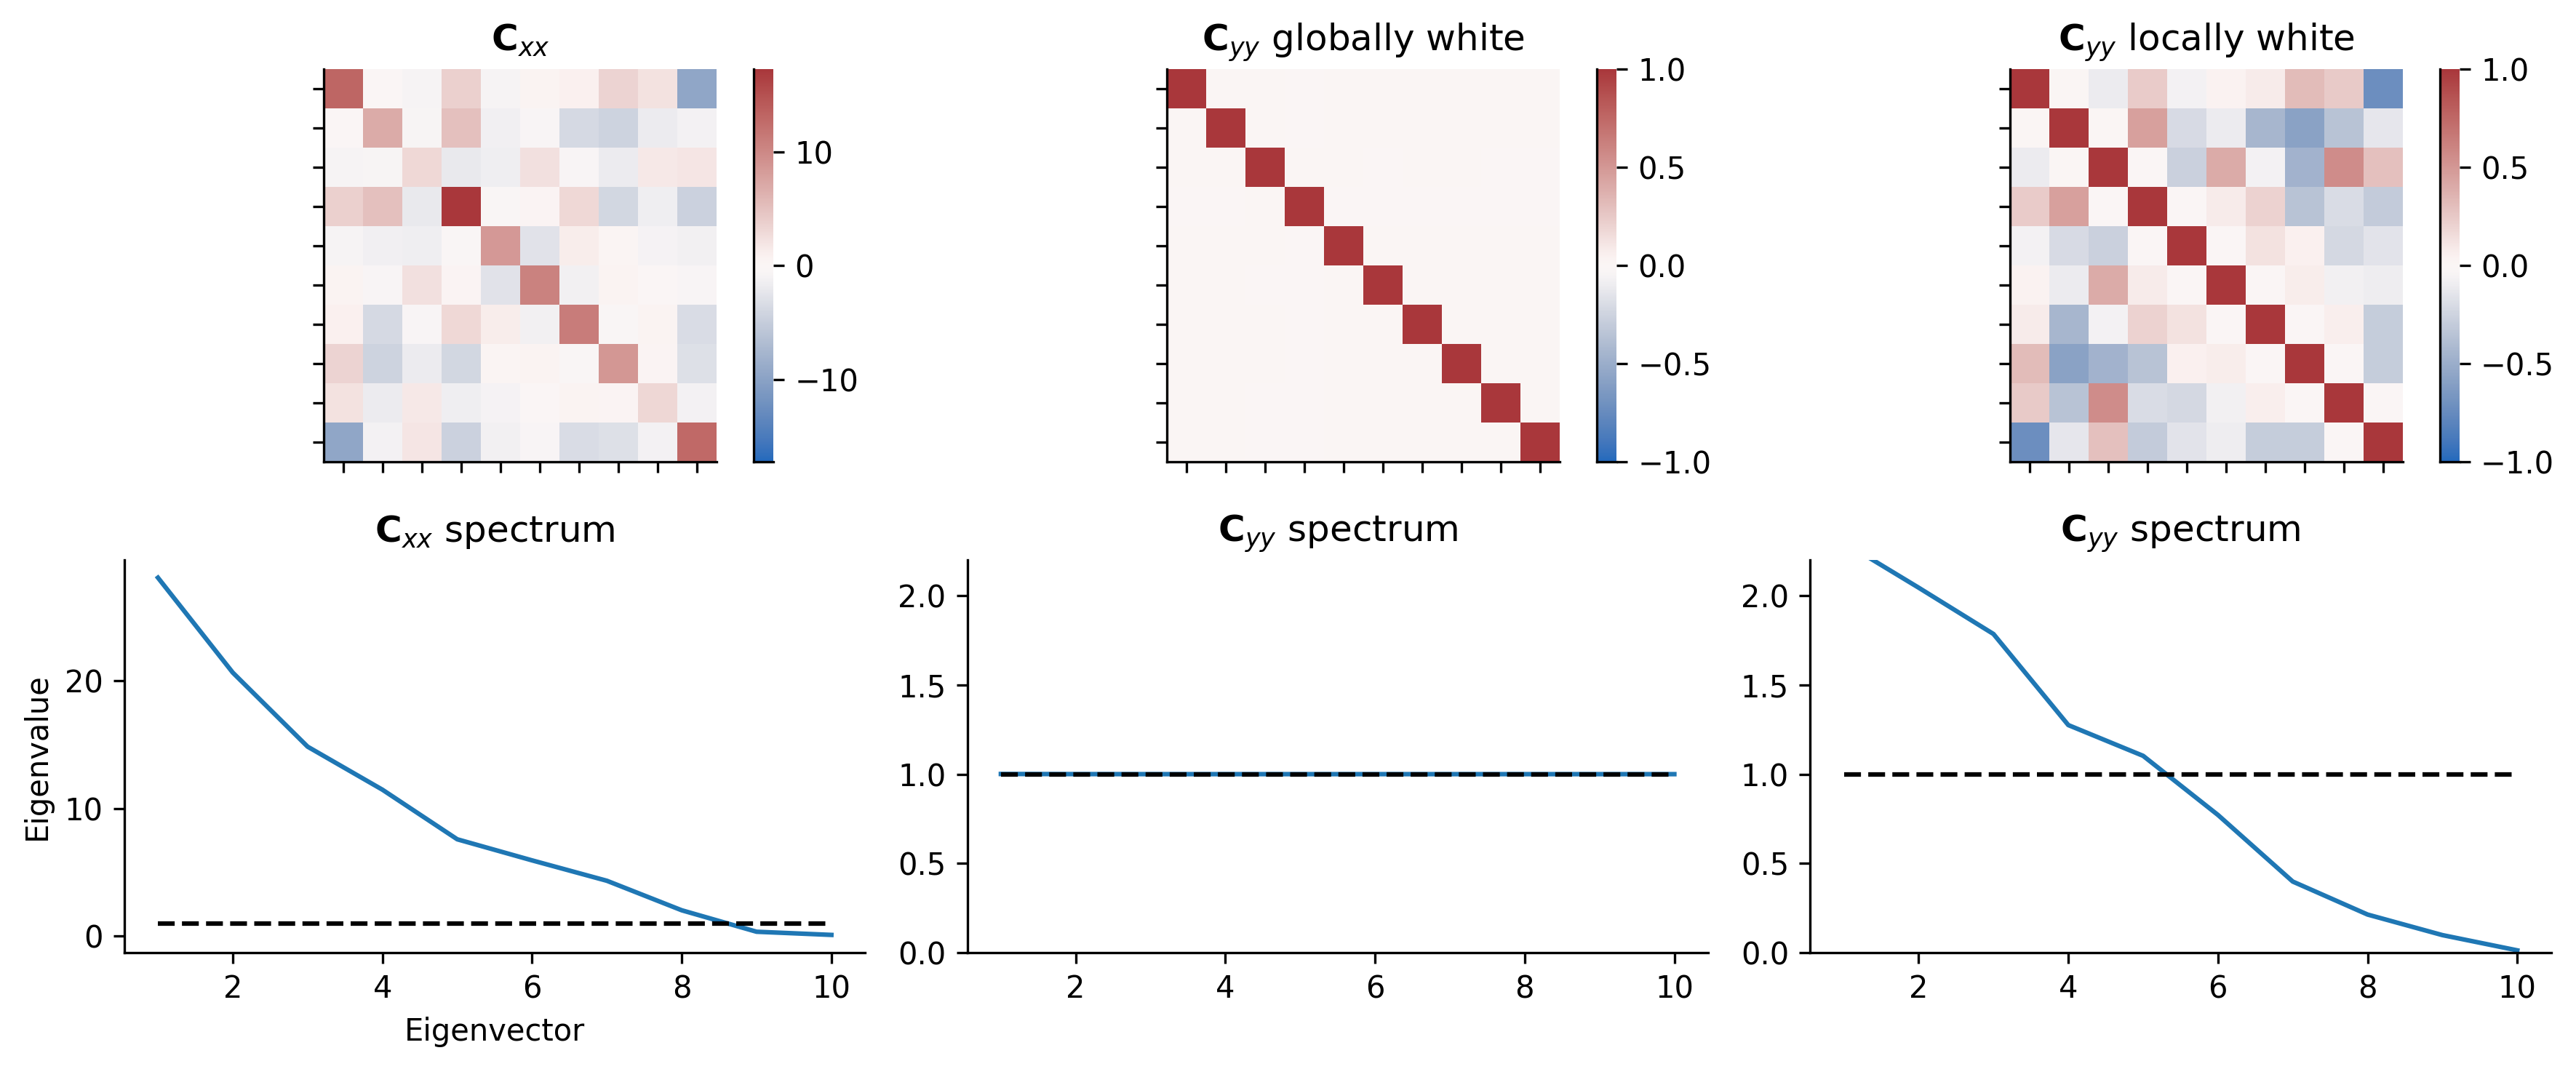

In [61]:
ev, V = np.linalg.eigh(Cxx)

Mw = V @ np.diag(1/np.sqrt(ev)) @ V.T

Cw2 = M @ Cxx0 @ M.T

vv, _ = np.linalg.eigh(Cw2)
Cww = Mw @ Cxx0 @ Mw.T

def heatmap(C, ax):
    _VMAX = np.max(np.abs(C)) 
    sns.heatmap(C, ax=ax, vmin=-_VMAX, vmax=_VMAX, cmap="vlag", cbar=True, square=True)

fig, ax = plt.subplots(2, 3, figsize=(12, 5), dpi=300)

heatmap(Cxx0, ax[0,0])
heatmap(Cww, ax[0,1])
heatmap(Cw2, ax[0,2])

ax[1,0].plot(np.arange(1,N+1), np.linalg.eigh(Cxx0)[0][::-1])
ax[1,1].plot(np.arange(1, N+1), np.linalg.eigh(Cww)[0][::-1])
ax[1,2].plot(np.arange(1, N+1), np.linalg.eigh(Cw2)[0][::-1])

ax[1,0].hlines(1, 1, N, color="k", linestyle="--")
ax[1,1].hlines(1, 1, N, color="k", linestyle="--")
ax[1,2].hlines(1, 1, N, color="k", linestyle="--")


ax[0,0].set(title=r"${\bf C}_{xx}$", xticklabels=[], yticklabels=[])
ax[0,1].set(title=r"${\bf C}_{yy}$ globally white", xticklabels=[], yticklabels=[])
ax[0,2].set(title=r"${\bf C}_{yy}$ locally white", xticklabels=[], yticklabels=[])

yscale = "linear"
ax[1, 0].set(title=r"${\bf C}_{xx}$ spectrum", yscale=yscale, ylabel="Eigenvalue", xlabel="Eigenvector")
ax[1, 1].set(title=r"${\bf C}_{yy}$ spectrum", yscale=yscale, ylim=(0, 2.2))
ax[1, 2].set(title=r"${\bf C}_{yy}$ spectrum", yscale=yscale, ylim=(0, 2.2))

fig.tight_layout()
sns.despine()